In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.models import Sequential,load_model
from keras.layers import LSTM, Dense,Dropout,Bidirectional
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="tensorflow")
warnings.resetwarnings()


In [2]:
df = pd.read_csv('../dataset/distance_dataset.csv') 

X = df.drop('DataCenterID', axis=1)  # Features
y = df['DataCenterID']-3  # Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
unique_labels = np.unique(y_train.values)
print(unique_labels)
print(df.info())
num_classes = len(unique_labels)


[0 1 2]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TaskFileSize        2000 non-null   int64  
 1   TaskOutputFileSize  2000 non-null   int64  
 2   TaskFileLength      2000 non-null   int64  
 3   UserLatitude        2000 non-null   float64
 4   UserLongitude       2000 non-null   float64
 5   DataCenterID        2000 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 93.9 KB
None


In [3]:
# sns.pairplot(df, hue='DataCenterID')
# plt.show()

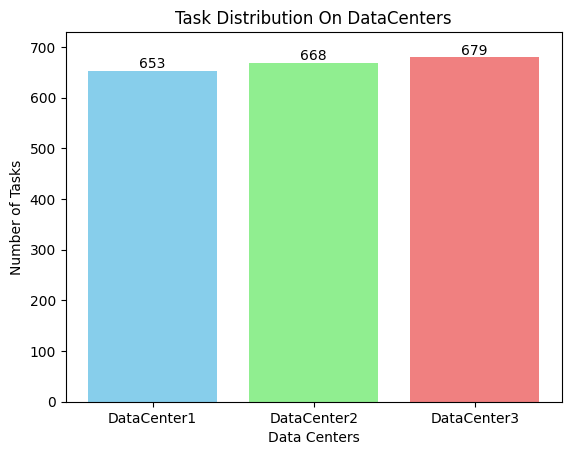

In [4]:

data_center_labels = ['DataCenter1', 'DataCenter2', 'DataCenter3']
tasks_per_data_center = df['DataCenterID'].value_counts().sort_index()

# Assigning colors
colors = ['skyblue', 'lightgreen', 'lightcoral']

# Plotting
fig, ax = plt.subplots()
bars = ax.bar(data_center_labels, tasks_per_data_center, color=colors)

# Displaying the task counts on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adjusting plot properties
plt.title('Task Distribution On DataCenters')
plt.xlabel('Data Centers')
plt.ylabel('Number of Tasks')
plt.ylim(0, max(tasks_per_data_center) + 50)  # Adjust y-axis limit for better visibility
plt.show()


In [5]:
if (len(X_train.shape)<3):
    X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(" xtrain ", X_train.shape, "\n", "ytrain ", y_train.shape, "\n", "xtest  ", X_test.shape, "\n", "ytest ", y_test.shape, "\n")




 xtrain  (1600, 1, 5) 
 ytrain  (1600,) 
 xtest   (400, 1, 5) 
 ytest  (400,) 



In [6]:

def train_model_1(hyperparameters):
    # Build and train the model
    model = Sequential()
    model.add(LSTM(units=int(hyperparameters['units']), input_shape=(1, X_train.shape[2]), return_sequences=True))
    model.add(Dropout(hyperparameters['dropout_rate']))
    model.add(LSTM(units=int(hyperparameters['units']) // 2))
    model.add(Dense(units=num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=hyperparameters['learning_rate']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    hist = model.fit(X_train, y_train,
                        epochs=100,
                        batch_size=int(hyperparameters['batch_size']),
                        validation_data=(X_test, y_test),
                       )
    return model,hist

def train_model_2(hyperparameters):
    model = Sequential()
    model.add(Bidirectional(LSTM(hyperparameters["units"], activation='tanh', return_sequences=True), input_shape=(X_train.shape[1],  5))) 
    model.add(Dropout(hyperparameters["dropout_rate"]))
    model.add(Bidirectional(LSTM(int(hyperparameters["units"]/2), activation='tanh', return_sequences=True)))
    model.add(Dropout(hyperparameters["dropout_rate"]))
    model.add(Bidirectional(LSTM(int(hyperparameters["units"]/4), activation='tanh')))
    model.add(Dropout(hyperparameters["dropout_rate"]))
    model.add(Dense(1, activation='softmax'))

    opt = Adam(learning_rate=hyperparameters["learning_rate"])
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
    hist = model.fit(X_train, y_train,
                     epochs=100,
                     batch_size=int(hyperparameters['batch_size']),
                     validation_data=(X_test, y_test),
                     callbacks=[early_stopping])
    return model, hist


SNAKE_hyperparameters = {'units': 128, 'dropout_rate': 0.01, 'learning_rate': 0.001, 'batch_size': 32}
print(" model 1 training start ....\n")
model1,history1= train_model_1(SNAKE_hyperparameters)
print(" \n\n model 2 training start ....\n")
print(" model 2 training start ....\n")

model2,history2= train_model_2(SNAKE_hyperparameters)

model1_accuracy = max(history1.history["accuracy"])
model2_accuracy = max(history2.history["accuracy"])

 model 1 training start ....


Epoch 1/100


50/50 [==============================] - 15s 80ms/step - loss: 0.7894 - accuracy: 0.6831 - val_loss: 0.5427 - val_accuracy: 0.7550
Epoch 2/100
50/50 [==============================] - 1s 12ms/step - loss: 0.5201 - accuracy: 0.7806 - val_loss: 0.4347 - val_accuracy: 0.8150
Epoch 3/100
50/50 [==============================] - 1s 13ms/step - loss: 0.4497 - accuracy: 0.8131 - val_loss: 0.4015 - val_accuracy: 0.8175
Epoch 4/100
50/50 [==============================] - 0s 10ms/step - loss: 0.4293 - accuracy: 0.8200 - val_loss: 0.4261 - val_accuracy: 0.8250
Epoch 5/100
50/50 [==============================] - 0s 9ms/step - loss: 0.4138 - accuracy: 0.8256 - val_loss: 0.4053 - val_accuracy: 0.8150
Epoch 6/100
50/50 [==============================] - 1s 11ms/step - loss: 0.4053 - accuracy: 0.8313 - val_loss: 0.4119 - val_accuracy: 0.8050
Epoch 7/100
50/50 [==============================] - 1s 12ms/step - loss: 0.4009 - accuracy: 0.8250 - val_loss: 0.3

In [7]:
print("model 1  Accuracy: ",np.round(model1_accuracy* 100) ,'%')
print("model 2 Accuracy: ",np.round(model2_accuracy* 100) ,'%')

model 1  Accuracy:  91.0 %
model 2 Accuracy:  33.0 %


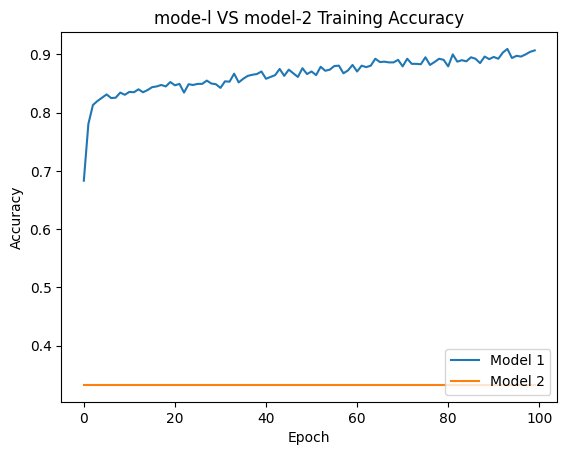

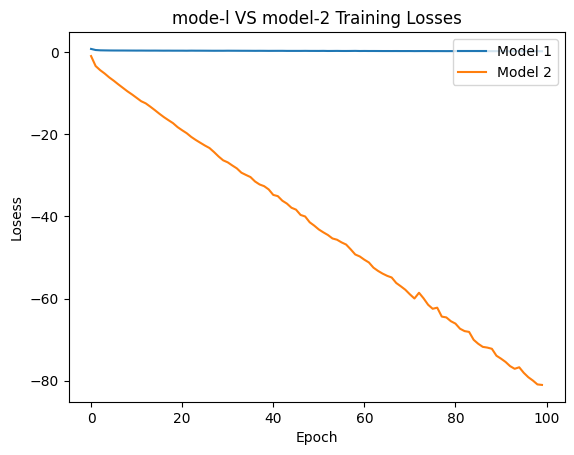



Model 1 model summary
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            68608     
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 118211 (461.76 KB)
Trainable params: 118211 (461.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Model 2 model summary
Model: "sequential_1"
_________________________________________________________________
 Layer 

In [8]:
plt.plot(history1.history['accuracy'])
plt.plot(history2.history['accuracy'])
plt.title('mode-l VS model-2 Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Model 1', 'Model 2'], loc='lower right')
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history2.history['loss'])
plt.title('mode-l VS model-2 Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Losess')
plt.legend(['Model 1', 'Model 2'], loc='upper right')
plt.show()

print("\n\nModel 1 model summary")
print(model1.summary())
print("\n\nModel 2 model summary")
print(model2.summary())



13/13 [==============================] - 3s 4ms/step


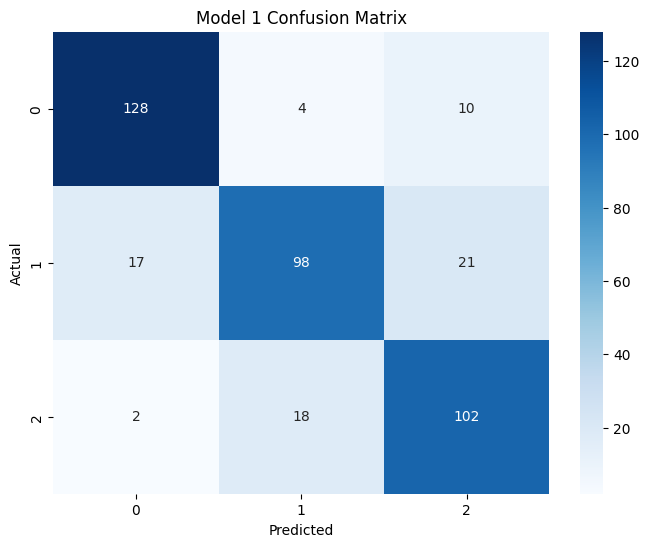

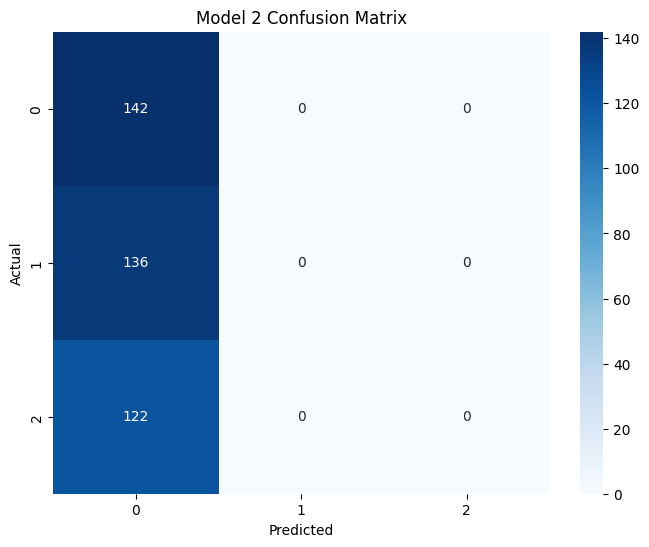

In [9]:
# confusing matrix

model1_y_pred = model1.predict(X_test)
model1_y_pred_classes = np.argmax(model1_y_pred, axis=1)

model2_y_pred = model2.predict(X_test)
model2_y_pred_classes = np.argmax(model2_y_pred, axis=1)

# Create a confusion matrix
model1_cm = confusion_matrix(y_test, model1_y_pred_classes)
model2_cm = confusion_matrix(y_test, model2_y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(model1_cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Model 1 Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


plt.figure(figsize=(8, 6))
sns.heatmap(model2_cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Model 2 Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [10]:
# model1.save('../models/model1.keras')
# model2.save('../models/model2.keras')


# SNAKE ALGORITHM

In [ ]:

# Define the Search Space
units = [32, 64, 128]
dropout_rates = [0.1, 0.2, 0.3]
learning_rates = [0.001, 0.005]
batch_sizes = [32, 64]

# Initial Random Selection from Search Space
current_hyperparameters = {
    "units": np.random.choice(units),
    "dropout_rate": np.random.choice(dropout_rates),
    "learning_rate": np.random.choice(learning_rates),
    "batch_size": np.random.choice(batch_sizes)
}

# Store the best hyperparameters and accuracy
best_hyperparameters = None
best_accuracy = 0

# Function to train a model with given hyperparameters

# SOA Loop
for iteration in range(10):
    _,hist = train_model_2(current_hyperparameters)
    accuracy=hist.history["accuracy"][-1]
    # Update best hyperparameters if better ones are found
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hyperparameters = current_hyperparameters.copy()

        # Greedy Exploitation: Refine search around the best hyperparameters
        # Here, we're perturbing the hyperparameters slightly
        current_hyperparameters = {
            "units": max(32, best_hyperparameters["units"] + np.random.choice([-16, 16])),
            "dropout_rate": min(0.3, max(0.1, best_hyperparameters["dropout_rate"] + np.random.choice([-0.1, 0.1]))),
            "learning_rate": min(0.005, max(0.001, best_hyperparameters["learning_rate"] * np.random.choice([0.5, 1.5]))),
            "batch_size": max(32, best_hyperparameters["batch_size"] + np.random.choice([-16, 16]))
        }
    else:
        # Random Exploration
        current_hyperparameters = {
            "units": np.random.choice(units),
            "dropout_rate": np.random.choice(dropout_rates),
            "learning_rate": np.random.choice(learning_rates),
            "batch_size": np.random.choice(batch_sizes)
        }

print("Best Hyperparameters:", best_hyperparameters)


Epoch 1/100
50/50 [==============================] - 21s 75ms/step - loss: -3.0740 - accuracy: 0.3325 - val_loss: -4.8702 - val_accuracy: 0.3400
Epoch 2/100
50/50 [==============================] - 0s 8ms/step - loss: -7.6666 - accuracy: 0.3325 - val_loss: -8.4509 - val_accuracy: 0.3400
Epoch 3/100
50/50 [==============================] - 0s 7ms/step - loss: -11.5727 - accuracy: 0.3325 - val_loss: -11.7781 - val_accuracy: 0.3400
Epoch 4/100
50/50 [==============================] - 0s 8ms/step - loss: -15.5956 - accuracy: 0.3325 - val_loss: -14.5754 - val_accuracy: 0.3400
Epoch 5/100
50/50 [==============================] - 0s 8ms/step - loss: -19.2924 - accuracy: 0.3325 - val_loss: -18.4904 - val_accuracy: 0.3400
Epoch 6/100
50/50 [==============================] - 0s 7ms/step - loss: -21.9902 - accuracy: 0.3325 - val_loss: -21.1510 - val_accuracy: 0.3400
Epoch 7/100
50/50 [==============================] - 0s 7ms/step - loss: -26.4735 - accuracy: 0.3325 - val_loss: -24.4948 - val_accu